## Build cart model

In [8]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [9]:
def cartpend(y, t):
    u = 0
    m = 1
    M = 5
    L = 2
    g = -9.8
    d = 1

    x, dx, theta, dtheta = y
    Sy = math.sin(theta)
    Cy = math.cos(theta)
    D = m*L*L*(M+m*(1-Cy**2))
    
    y1 = dx
    y2 = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*dtheta**2*Sy - d*dx)) + m*L*L*(1/D)*u
    y3 = dtheta
    y4 = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*dtheta**2*Sy - d*dx)) - m*L*Cy*(1/D)*u

    dydt = [y1, y2, y3, y4]

    return dydt


y0 = [0, 0, math.pi, .5]
t = np.linspace(0, 20, 1001)
y = odeint(cartpend, y0, t)


## Plot result

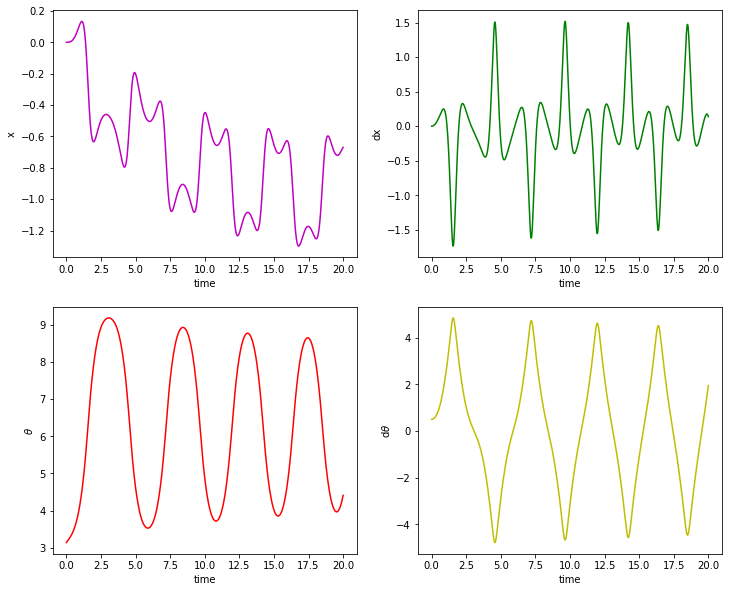

In [10]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(t,[row[0] for row in y], 'm')
plt.xlabel('time')
plt.ylabel('x')

plt.subplot(222)
plt.plot(t,[row[1] for row in y], 'g')
plt.xlabel('time')
plt.ylabel('dx')

plt.subplot(223)
plt.plot(t,[row[2] for row in y], 'r')
plt.xlabel('time')
plt.ylabel(r'$\theta$')

plt.subplot(224)
plt.plot(t,[row[3] for row in y], 'y')
plt.xlabel('time')
plt.ylabel('d' + r'$\theta$')
plt.show()



## Set animation